In [35]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import zipfile
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
from tensorflow.keras.optimizers import Adam
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
image_count = 0
labels = []
train_counts = []
for dirname in os.listdir('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/train'):
    labels.append(dirname)
    image_count = 0
    for img in os.listdir(os.path.join('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/train',dirname)):
        image_count +=1
    train_counts.append(image_count)

print(list(zip(train_counts,labels)))

[(354, 'glass'), (286, 'metal'), (403, 'paper'), (287, 'cardboard'), (347, 'plastic'), (91, 'trash')]


In [38]:
class_weights = []
total_samples = train_generator.samples              #1768
total_classes = len(train_generator.class_indices)   #6
for ele in train_counts:
    result = round(total_samples / (total_classes * ele),2)
    class_weights.append(result)
print(dict(zip(labels,class_weights)))

class_weights = dict(zip(train_generator.class_indices.values(),class_weights))

{'glass': 0.83, 'metal': 1.03, 'paper': 0.73, 'cardboard': 1.03, 'plastic': 0.85, 'trash': 3.24}


In [39]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                  )

# Note that the validation data should not be augmented!
valid_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 8 using train_datagen generator
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/train',
                                                    batch_size =8,
                                                    class_mode = 'categorical', 
                                                    target_size = (150,150))     

# Flow validation images in batches of 4 using valid_datagen generator
validation_generator =  valid_datagen.flow_from_directory( '/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/valid',
                                                          batch_size  = 4,
                                                          class_mode  = 'categorical', 
                                                          target_size = (150,150))     

# Flow test images using test_datagen generator
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/01- DOUTORADO/01- Deep Learning/Dataset/split-garbage-dataset/test',
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  target_size = (150,150),shuffle = False)     

Found 1768 images belonging to 6 classes.
Found 328 images belonging to 6 classes.
Found 431 images belonging to 6 classes.


## Model Creation
1) CNN convencional: conv-->maxpool-->conv-->maxpool-->Densa-->Densa-->predição

2) CNN + dropout: conv-->maxpool-->conv-->maxpool-->Densa-->Dropout-->Densa-->predição

3) CNN + batch normalization: conv-->BN-->ReLu-->maxpool-->conv-->BN-->ReLu-->maxpool-->Densa-->Densa-->predição

4) CNN + Global average pooling: conv-->maxpool-->conv-->GAP-->Densa-->Densa-->predição

In [40]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
#learning rate
learning_rate = 0.0001

In [44]:
tf.keras.backend.clear_session()
model =  models.Sequential()
model.add(layers.Conv2D(20, (3,3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(10, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(15, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer=optimizers.RMSprop(learning_rate), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 20)      560       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 10)        1810      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12960)             0         
_________________________________________________________________
dense (Dense)                (None, 15)                194415    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 9

In [45]:
gpu_name = tf.test.gpu_device_name()
if gpu_name != '/device:GPU:0':
  raise SystemError('no GPUs')
print('GPUs found: {}'.format(gpu_name))

GPUs found: /device:GPU:0


In [46]:
def train_gpu():
  with tf.device('/device:GPU:0'):
    model_history =  model.fit(train_generator, 
                               steps_per_epoch = train_generator.samples/train_generator.batch_size, 
                               epochs=50, 
                               validation_data = validation_generator,
                               validation_steps= validation_generator.samples/validation_generator.batch_size, 
                               class_weight = class_weights )

  return model_history
model_history = train_gpu()

Epoch 1/50
221/221 [==============================] - 678s 3s/step - loss: 1.7973 - acc: 0.2094 - val_loss: 1.7381 - val_acc: 0.2134
Epoch 2/50
221/221 [==============================] - 21s 93ms/step - loss: 1.6947 - acc: 0.2868 - val_loss: 1.5785 - val_acc: 0.3994
Epoch 3/50
221/221 [==============================] - 20s 90ms/step - loss: 1.6001 - acc: 0.3631 - val_loss: 1.6492 - val_acc: 0.3018
Epoch 4/50
221/221 [==============================] - 20s 90ms/step - loss: 1.5522 - acc: 0.3813 - val_loss: 1.5150 - val_acc: 0.3750
Epoch 5/50
221/221 [==============================] - 20s 89ms/step - loss: 1.5103 - acc: 0.3948 - val_loss: 1.4745 - val_acc: 0.4268
Epoch 6/50
221/221 [==============================] - 20s 91ms/step - loss: 1.4629 - acc: 0.4198 - val_loss: 1.4751 - val_acc: 0.4360
Epoch 7/50
221/221 [==============================] - 20s 92ms/step - loss: 1.4399 - acc: 0.4226 - val_loss: 1.4440 - val_acc: 0.3902
Epoch 8/50
221/221 [==============================] - 20s 91ms/

## Accuracy Graph

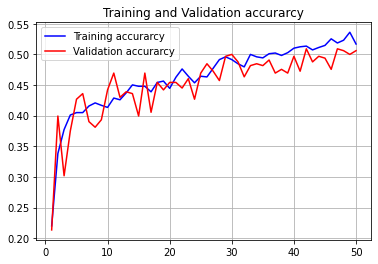

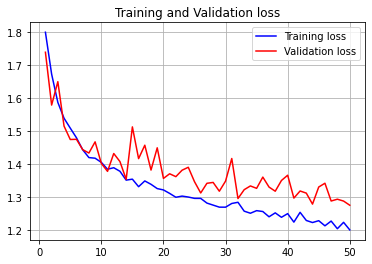

In [47]:

#Plot training and validation curves (Accuracy and Loss)
acc = model_history.history['acc']
val_acc = model_history.history['val_acc']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epoch_num = range(1, len(acc) +1)

#Train and validation accuracy
plt.plot(epoch_num, acc, 'b', label='Training accurarcy')
plt.plot(epoch_num, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.grid(True)
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epoch_num, loss, 'b', label='Training loss')
plt.plot(epoch_num, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.grid(True)
plt.legend()

plt.show()

In [57]:
model.evaluate(test_generator,batch_size = 1) 

431/431 [==============================] - 281s 654ms/step - loss: 1.1630 - acc: 0.5313


[1.1630299091339111, 0.5313224792480469]

              precision    recall  f1-score   support

           0       0.80      0.67      0.73        70
           1       0.44      0.37      0.40        82
           2       0.42      0.16      0.23        68
           3       0.52      0.77      0.62       108
           4       0.58      0.54      0.56        74
           5       0.38      0.62      0.47        29

    accuracy                           0.53       431
   macro avg       0.52      0.52      0.50       431
weighted avg       0.53      0.53      0.51       431



Text(0.5, 1.0, 'Confusion matrix of model')

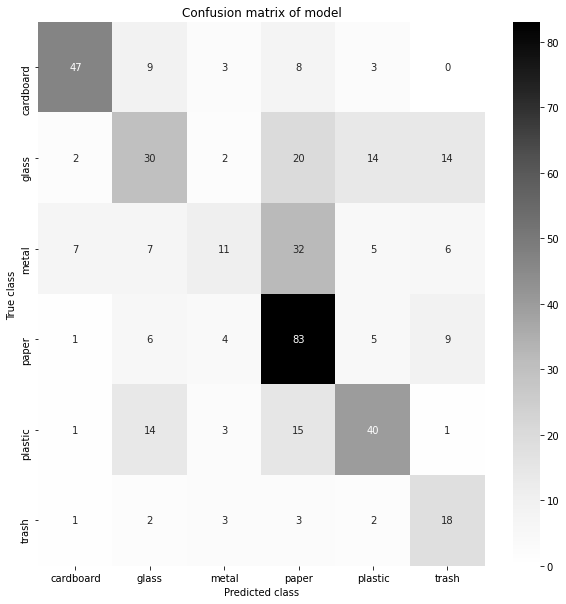

In [58]:
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(), annot=True, cmap="Greys")
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')

# Modelo 2

In [60]:
model2 =  models.Sequential()
model2.add(layers.Conv2D(20, (3,3), activation='relu', input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Dropout(0.5))
model2.add(layers.Conv2D(10, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Dropout(0.5))
#model.add(layers.Conv2D(128, (3,3), activation='relu'))
#model.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
model2.add(layers.Dense(15, activation='relu'))
model2.add(layers.Dropout(0.4))
model2.add(layers.Dense(6, activation='softmax'))

model2.compile(optimizer=optimizers.RMSprop(learning_rate), loss='categorical_crossentropy', metrics=['acc'])



In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 198, 198, 20)      560       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 99, 99, 20)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 97, 97, 10)        1810      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 23040)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                345615    
_________________________________________________________________
dropout (Dropout)            (None, 15)               

In [ ]:
def train_gpu():
  with tf.device('/device:GPU:0'):
    model2_history = model2.fit_generator(train_generator, 
                               steps_per_epoch = train_generator.samples/train_generator.batch_size, 
                               epochs=50, 
                               validation_data = validation_generator,
                               validation_steps= validation_generator.samples/validation_generator.batch_size, 
                               class_weight = class_weights )
  return model2_history
model2_history = train_gpu()


Epoch 1/200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


221/221 [==============================] - 17s 76ms/step - loss: 1.8296 - acc: 0.2136 - val_loss: 1.7280 - val_acc: 0.2530
Epoch 2/200
221/221 [==============================] - 16s 74ms/step - loss: 1.7585 - acc: 0.2030 - val_loss: 1.7161 - val_acc: 0.2774
Epoch 3/200
221/221 [==============================] - 16s 74ms/step - loss: 1.7562 - acc: 0.2880 - val_loss: 1.6152 - val_acc: 0.3476
Epoch 4/200
221/221 [==============================] - 16s 74ms/step - loss: 1.6798 - acc: 0.3267 - val_loss: 1.5615 - val_acc: 0.3628
Epoch 5/200
221/221 [==============================] - 17s 76ms/step - loss: 1.6591 - acc: 0.3261 - val_loss: 1.5088 - val_acc: 0.3628
Epoch 6/200
221/221 [==============================] - 16s 73ms/step - loss: 1.6315 - acc: 0.3471 - val_loss: 1.5496 - val_acc: 0.3841
Epoch 7/200
221/221 [==============================] - 17s 77ms/step - loss: 1.6274 - acc: 0.3188 - val_loss: 1.4956 - val_acc: 0.3811
Epoch 8/200
221/221 [==============================] - 16s 72ms/ste

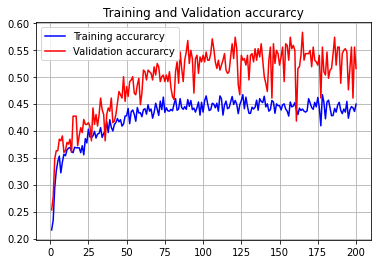

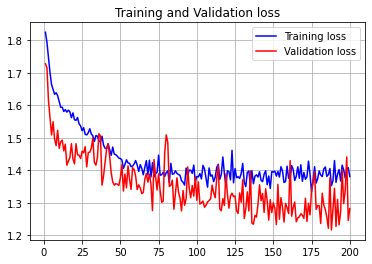

In [ ]:
#Plot training and validation curves (Accuracy and Loss)
acc = model2_history.history['acc']
val_acc = model2_history.history['val_acc']
loss = model2_history.history['loss']
val_loss = model2_history.history['val_loss']

epoch_num = range(1, len(acc) +1)

#Train and validation accuracy
plt.plot(epoch_num, acc, 'b', label='Training accurarcy')
plt.plot(epoch_num, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.grid(True)
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epoch_num, loss, 'b', label='Training loss')
plt.plot(epoch_num, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
model2.evaluate(test_generator,batch_size = 1) 

431/431 [==============================] - 2s 5ms/step - loss: 1.2494 - acc: 0.5499


[1.249448299407959, 0.5498839616775513]

              precision    recall  f1-score   support

           0       0.91      0.71      0.80        70
           1       0.44      0.39      0.42        82
           2       0.62      0.12      0.20        68
           3       0.61      0.82      0.70       108
           4       0.60      0.51      0.55        74
           5       0.24      0.69      0.36        29

    accuracy                           0.55       431
   macro avg       0.57      0.54      0.50       431
weighted avg       0.60      0.55      0.54       431



Text(0.5, 1.0, 'Confusion matrix of model')

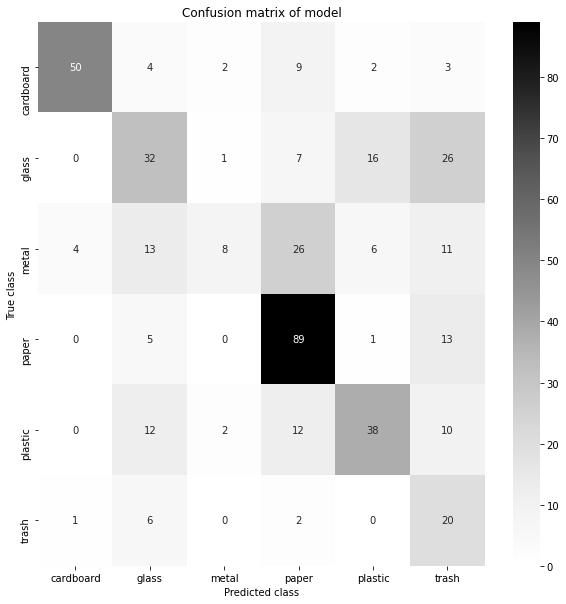

In [ ]:
y_pred = model2.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(), annot=True, cmap="Greys")
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')

# Modelo 3

In [ ]:
model3 =  models.Sequential()
model3.add(layers.Conv2D(20, (3,3), activation='relu', input_shape=(200, 200, 3)))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Dropout(0.5))
model3.add(layers.Conv2D(10, (3,3), activation='relu'))
model3.add(layers.BatchNormalization())
model3.add(layers.Activation('relu'))
model3.add(layers.MaxPooling2D((2,2)))
#model.add(layers.Dropout(0.5))
#model.add(layers.Conv2D(128, (3,3), activation='relu'))
#model.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Flatten())
#model.add(layers.Dropout(0.5))
model3.add(layers.Dense(15, activation='relu'))
#model2.add(layers.Dropout(0.4))
model3.add(layers.Dense(6, activation='softmax'))

model3.compile(optimizer=optimizers.RMSprop(learning_rate), loss='categorical_crossentropy', metrics=['acc'])



In [ ]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 20)      560       
_________________________________________________________________
batch_normalization (BatchNo (None, 148, 148, 20)      80        
_________________________________________________________________
activation (Activation)      (None, 148, 148, 20)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 10)        1810      
_________________________________________________________________
batch_normalization_1 (Batch (None, 72, 72, 10)        40        
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 10)       

In [ ]:


def train_gpu():
  with tf.device('/device:GPU:0'):
    model3_history = model3.fit_generator(train_generator, 
                               steps_per_epoch = train_generator.samples/train_generator.batch_size, 
                               epochs=50, 
                               validation_data = validation_generator,
                               validation_steps= validation_generator.samples/validation_generator.batch_size, 
                               class_weight = class_weights )
  return model3_history
model3_history = train_gpu()


Epoch 1/200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


221/221 [==============================] - 18s 76ms/step - loss: 1.9151 - acc: 0.2310 - val_loss: 1.7699 - val_acc: 0.2439
Epoch 2/200
221/221 [==============================] - 17s 76ms/step - loss: 1.7685 - acc: 0.3585 - val_loss: 1.6173 - val_acc: 0.3323
Epoch 3/200
221/221 [==============================] - 17s 75ms/step - loss: 1.5872 - acc: 0.4117 - val_loss: 1.5032 - val_acc: 0.3720
Epoch 4/200
221/221 [==============================] - 17s 75ms/step - loss: 1.6548 - acc: 0.3734 - val_loss: 1.4647 - val_acc: 0.4543
Epoch 5/200
221/221 [==============================] - 17s 77ms/step - loss: 1.5772 - acc: 0.4358 - val_loss: 1.5149 - val_acc: 0.4909
Epoch 6/200
221/221 [==============================] - 16s 74ms/step - loss: 1.5364 - acc: 0.4323 - val_loss: 1.4885 - val_acc: 0.4787
Epoch 7/200
221/221 [==============================] - 17s 76ms/step - loss: 1.4521 - acc: 0.4734 - val_loss: 1.5406 - val_acc: 0.4848
Epoch 8/200
221/221 [==============================] - 17s 78ms/ste

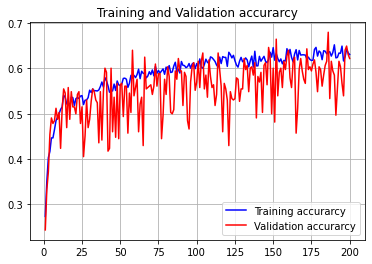

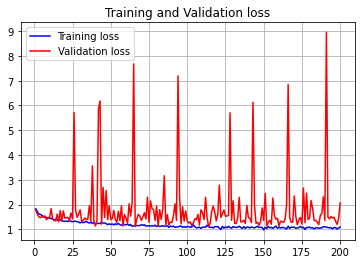

In [ ]:
#Plot training and validation curves (Accuracy and Loss)
acc = model3_history.history['acc']
val_acc = model3_history.history['val_acc']
loss = model3_history.history['loss']
val_loss = model3_history.history['val_loss']

epoch_num = range(1, len(acc) +1)

#Train and validation accuracy
plt.plot(epoch_num, acc, 'b', label='Training accurarcy')
plt.plot(epoch_num, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.grid(True)
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epoch_num, loss, 'b', label='Training loss')
plt.plot(epoch_num, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
model3.evaluate(test_generator,batch_size = 1) 

431/431 [==============================] - 2s 5ms/step - loss: 2.0763 - acc: 0.5360


[2.0763444900512695, 0.5359628796577454]

              precision    recall  f1-score   support

           0       0.88      0.74      0.81        70
           1       0.40      0.44      0.42        82
           2       0.54      0.65      0.59        68
           3       0.79      0.43      0.55       108
           4       0.37      0.66      0.47        74
           5       0.44      0.14      0.21        29

    accuracy                           0.54       431
   macro avg       0.57      0.51      0.51       431
weighted avg       0.60      0.54      0.54       431



Text(0.5, 1.0, 'Confusion matrix of model')

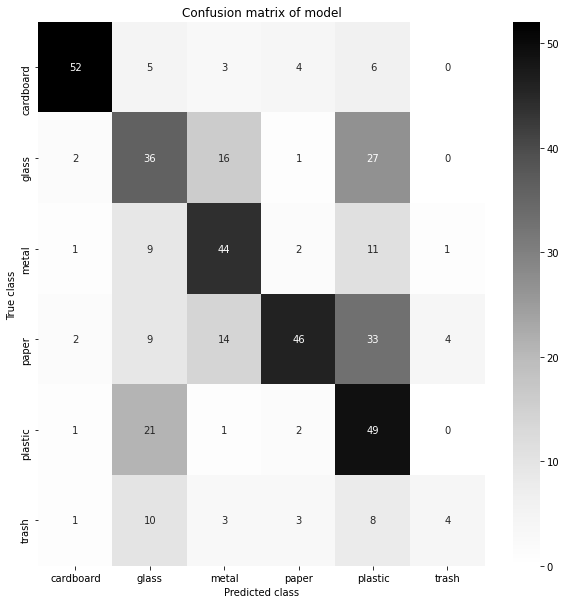

In [ ]:
y_pred = model3.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(), annot=True, cmap="Greys")
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')

# Modelo 4

In [ ]:
learning_rate = 0.0001

model4 =  models.Sequential()
model4.add(layers.Conv2D(20, (3,3), activation='relu', input_shape=(200, 200, 3), padding='valid'))
model4.add(layers.MaxPooling2D((2,2), strides=None))
model4.add(layers.Conv2D(10, (3,3), activation='relu', padding='valid'))
#model4.add(layers.GlobalAveragePooling2D())
model4.add(layers.Flatten())
model4.add(layers.Dense(15, activation='relu'))
model4.add(layers.Dense(6, activation='softmax'))

model4.compile(optimizer=optimizers.RMSprop(learning_rate), loss='categorical_crossentropy', metrics=['acc'])



In [ ]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 20)      560       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 10)        1810      
_________________________________________________________________
flatten_3 (Flatten)          (None, 51840)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 15)                777615    
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 96        
Total params: 780,081
Trainable params: 780,081
Non-trainable params: 0
________________________________________________

In [ ]:


def train_gpu():
  with tf.device('/device:GPU:0'):
    model4_history = model4.fit_generator(train_generator, 
                               steps_per_epoch = train_generator.samples/train_generator.batch_size, 
                               epochs=50, 
                               validation_data = validation_generator,
                               validation_steps= validation_generator.samples/validation_generator.batch_size, 
                               class_weight = class_weights )
  return model4_history
model4_history = train_gpu()



Epoch 1/200


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


221/221 [==============================] - 17s 74ms/step - loss: 1.8071 - acc: 0.1969 - val_loss: 1.6903 - val_acc: 0.2500
Epoch 2/200
221/221 [==============================] - 16s 75ms/step - loss: 1.7316 - acc: 0.2444 - val_loss: 1.6413 - val_acc: 0.2896
Epoch 3/200
221/221 [==============================] - 17s 75ms/step - loss: 1.6464 - acc: 0.2938 - val_loss: 1.5169 - val_acc: 0.3171
Epoch 4/200
221/221 [==============================] - 16s 74ms/step - loss: 1.5933 - acc: 0.3308 - val_loss: 1.5521 - val_acc: 0.3963
Epoch 5/200
221/221 [==============================] - 17s 75ms/step - loss: 1.5359 - acc: 0.3802 - val_loss: 1.4754 - val_acc: 0.4146
Epoch 6/200
221/221 [==============================] - 17s 76ms/step - loss: 1.4953 - acc: 0.4058 - val_loss: 1.4441 - val_acc: 0.4360
Epoch 7/200
221/221 [==============================] - 17s 78ms/step - loss: 1.4598 - acc: 0.4137 - val_loss: 1.4244 - val_acc: 0.4055
Epoch 8/200
221/221 [==============================] - 16s 74ms/ste

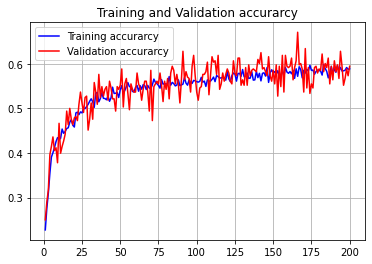

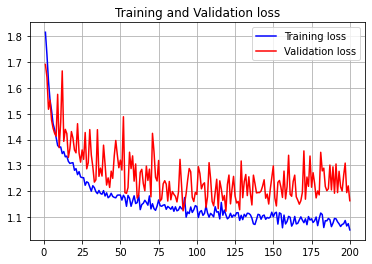

In [ ]:
#Plot training and validation curves (Accuracy and Loss)
acc = model4_history.history['acc']
val_acc = model4_history.history['val_acc']
loss = model4_history.history['loss']
val_loss = model4_history.history['val_loss']

epoch_num = range(1, len(acc) +1)

#Train and validation accuracy
plt.plot(epoch_num, acc, 'b', label='Training accurarcy')
plt.plot(epoch_num, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.grid(True)
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epoch_num, loss, 'b', label='Training loss')
plt.plot(epoch_num, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
model4.evaluate(test_generator,batch_size = 1) 

431/431 [==============================] - 2s 6ms/step - loss: 1.0794 - acc: 0.5963


[1.0793730020523071, 0.596287727355957]

              precision    recall  f1-score   support

           0       0.92      0.69      0.79        70
           1       0.46      0.40      0.43        82
           2       0.64      0.31      0.42        68
           3       0.60      0.83      0.69       108
           4       0.68      0.64      0.66        74
           5       0.33      0.62      0.43        29

    accuracy                           0.60       431
   macro avg       0.60      0.58      0.57       431
weighted avg       0.63      0.60      0.59       431



Text(0.5, 1.0, 'Confusion matrix of model')

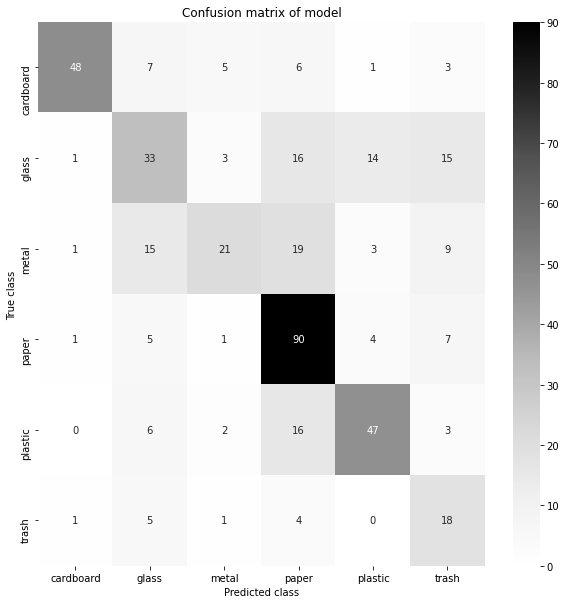

In [ ]:
y_pred = model4.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(test_generator.classes, y_pred))
cf_matrix = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(10,10))
heatmap = sns.heatmap(cf_matrix, xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys(), annot=True, cmap="Greys")
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')